In [ ]:
# | hide
# | default_exp functional
import nbdev
from nbdev.showdoc import *

nbdev.nbdev_export()

### Functional operations


In [ ]:
# | exporti
import numpy as np
from tidygrad.tensor import Tensor, UnaryElementwiseOp, BinaryElementwiseOp, BaseOp, ExpLog

In [ ]:
# | exporti
class Sigmoid(UnaryElementwiseOp):
    """Take the sigmoid of a tensor"""
    name_template = "sigmoid({})"

    def __init__(self, a, name=None):
        super().__init__(a, name=name)
        self.out = Tensor(1 / (1 + np.exp(-self.args[0].data)), name=self.name, op=self)

    def backward(self):
        with np.errstate(under="ignore"):  # Triggered by infinitesimally small 1-data
            self.parents[0].grad += self.out.grad * self.out.data * (1 - self.out.data)

In [ ]:
# | export
def sigmoid(input, name=None):
    return Sigmoid(input, name=name).out

In [ ]:
#| export
def softmax(input, name=None):
    exp = input.exp()
    return exp.div(exp.sum(axis=-1, keepdims=True), name=name)

In [ ]:
# | exporti
class Relu(UnaryElementwiseOp):
    """Take the sigmoid of a tensor"""

    name_template = "relu({})"

    def __init__(self, a, name=None):
        super().__init__(a, name=name)
        self.out = Tensor(np.maximum(0, self.args[0].data), name=self.name, op=self)

    def backward(self):
        self.parents[0].grad += self.out.grad * (self.out.data > 0)

In [ ]:
# | export
def relu(input, name=None):
    return Relu(input, name=name).out

In [ ]:
# | export
def BCE_loss(logits: Tensor, target: Tensor, reduction="mean"):
    loss = logits - logits*target + ExpLog(-logits).out
    if reduction == "mean": return loss.mean()
    if reduction == "sum": return loss.sum()
    assert 0, "Invalid reduction"

In [ ]:
#| export

def CrossEntropy_loss(logits: Tensor, target: Tensor, reduction="mean"):
    if not isinstance(target, Tensor): target = Tensor(target)
    sm = softmax(logits)
    loss = -target * sm.log()
    if reduction == "mean": return loss.mean()
    if reduction == "sum": return loss.sum()
    assert 0, "Invalid reduction"

In [ ]:
# | exporti
class Dropout(UnaryElementwiseOp):
    """Apply Dropout to a tensor"""

    name_template = "dropout({})"

    def __init__(self, a, p_drop=0.1, training=True, name=None):
        super().__init__(a, name=name)
        assert 0 < p_drop < 1, f"p_drop must in (0, 1), got {p_drop}"
        self.p_drop = p_drop
        self.training = training
        if training:
            # Note: We scale up the outputs during training rather than scaling down during inference.
            scale_factor = 1 / (1-p_drop)
            self.mask = np.random.binomial(scale_factor, 1 - p_drop, size=self.args[0].data.shape)
            self.out = Tensor(self.args[0].data * self.mask, name=self.name, op=self)
        else:
            self.out = Tensor(self.args[0].data, name=self.name, op=self)

    def backward(self):
        self.parents[0].grad += self.out.grad * (self.mask if self.training else 1)

In [ ]:
# | export
def dropout(x, p=0.5, training=True):
    if p == 0:
        return x

    return Dropout(x, p_drop=p, training=training).out

In [ ]:
def np_pad(a: np.ndarray, pad:int):
    pad = (((0, 0), ) * max(len(a.shape) - 2, 0)) + ((pad, pad), (pad, pad))
    return np.pad(a, pad, mode="constant")

In [ ]:
#| export

class Pad(UnaryElementwiseOp):
    """Pad a tensor"""
    name_template = "pad2d({})"

    def __init__(self, a, pad: int, name=None):
        super().__init__(a, name=name)
        assert len(self.args[0].shape) == 4, "Only 4D tensors supported for now. And we pad xy"
        self.padding = pad
        self.out = Tensor(np_pad(a.data, pad), name=self.name, op=self)


    def backward(self):
        self.parents[0].grad += self.out.grad[:, :, self.padding:-self.padding, self.padding:-self.padding]

In [ ]:
from matplotlib import pyplot as plt

<matplotlib.image.AxesImage>

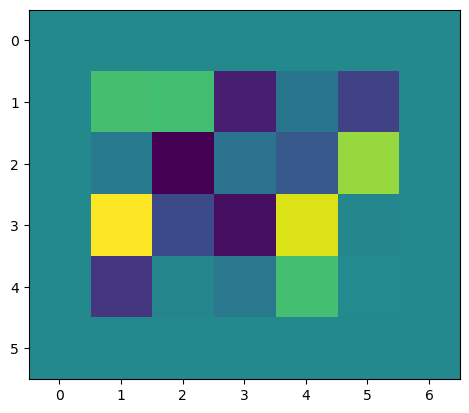

In [ ]:
padded_input = Tensor(np.random.randn(1, 1, 4, 5), name="x")
bias = Pad(padded_input, 1).out

plt.imshow(bias.data[0, 0, :, :])

In [ ]:
def np_conv2d(a:np.ndarray, w:np.ndarray, b:np.ndarray):
    batch, input_channels, input_height, input_width = a.shape
    output_channels, _input_channels, kernel_height, kernel_width = w.shape

    assert kernel_height % 2 == 1, "Only odd kernel sizes are supported for"
    assert kernel_width % 2 == 1, "Only odd kernel sizes are supported for"

    assert input_channels == _input_channels, f"Input channels mismatch: {input_channels} != {_input_channels}"
    assert b.shape == (output_channels, ), f"Invalid bias shape: {b.shape}"

    output_height = input_height - kernel_height + 1
    output_width = input_width - kernel_width + 1

    data = np.zeros((batch, output_channels, input_height - kernel_height + 1, input_width - kernel_width + 1), dtype=a.dtype)
    for i in range(0, output_height):
        for j in range(0, output_width):
            p = a[:, :, i:i + kernel_height, j:j + kernel_width]
            q = w
            m = p*q + b
            s = np.sum(m, axis=(-1, -2))
            data[:, :, i, j] = s

    return data

def np_kernel_grad(padded_input:np.ndarray, kernel:np.ndarray, bias:np.ndarray, grad:np.ndarray):
    batch, input_channels, input_height, input_width = padded_input.shape
    output_channels, _input_channels, kernel_height, kernel_width = kernel.shape

    assert kernel_height % 2 == 1, "Only odd kernel sizes are supported for"
    assert kernel_width % 2 == 1, "Only odd kernel sizes are supported for"

    assert input_channels == _input_channels, f"Input channels mismatch: {input_channels} != {_input_channels}"
    assert bias.shape == (output_channels, ), f"Invalid bias shape: {bias.shape}"

    output_height = input_height - kernel_height + 1
    output_width = input_width - kernel_width + 1

    # W      # [ output_channels, input_channels, kernel_height, kernel_width ]
    # a      # [ batch, input_channels, input_height, input_width
    # grad   # [ batch, output_channels, output_height, output_width ]

    grad_w = np.zeros_like(kernel)
    for i in range(0, output_height):
        for j in range(0, output_width):

            p = padded_input[:, :, i:i + kernel_height, j:j + kernel_width]
            for c in range(0, output_channels):
                q = grad[:, c, i, j]
                q=q[:, None, None]

                grad_w[c,:,:,:] += (p * q).sum(axis=0)

    return grad_w

In [ ]:
class Conv2D(BaseOp):
    def __init__(self, input, kernel, bias, stride=1, padding=0, name=None):
        super().__init__(input, kernel, bias, name=name)
        self.stride = stride
        assert stride == 1, "Only stride=1 is supported for now"
        assert padding == 1, "Only padding=1 is supported for now"
        self.padding = padding
        self.parents = [*self.args]

        if padding:
            input_data_padded = np_pad(self.args[0].data, pad=padding)

        data = np_conv2d(input_data_padded, kernel.data, bias.data)

        self.out = Tensor(data, name=self.name, op=self)

    def backward(self):
        input, kernel, bias = self.args
        grad = self.out.grad
        padded_grad = np_pad(grad, 1)   # XXX
        padded_input = np_pad(input.data, 1)
        print(padded_grad)
        t = np_conv2d(padded_grad, np.rot90(kernel.data, 2), np.zeros_like(bias.data))
        input.grad += t
        kernel.grad += np_kernel_grad(padded_input, kernel.data, bias.data, grad)

In [ ]:
from tidygrad.utils.grad_check import grad_check

In [ ]:
x = Tensor(np.eye(10, 10)[None, None], "x")
kernel = np.array( [[1., 2, 1],
                    [2, 4, 2],
                    [1, 2, 1]]
                ).reshape(1, 1, 3, 3)
kernel = Tensor(kernel, "w")

bias = Tensor(np.zeros((1, )), "b")

conv = Conv2D(x, kernel, bias, padding=1).out
loss = conv.mean()
loss.backward()

def func(inputs, params):
    x = params[0]
    kernel = params[1]
    # kernel = np.array( [[1., 2, 1],
    #                 [2, 4, 2],
    #                 [1, 2, 1]]
    #             ).reshape(1, 1, 3, 3)
    bias = Tensor(np.zeros((1, )), "b")
    return Conv2D(x, kernel, bias, padding=1).out.mean()

func(None, (x, kernel)).backward()

# grad_check(func, None, (x,kernel))

[[[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
   [0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.  ]
   [0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.  ]
   [0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.  ]
   [0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.  ]
   [0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.  ]
   [0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.  ]
   [0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.  ]
   [0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.  ]
   [0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.  ]
   [0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.  ]
   [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]]]
[[[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
   [0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.  ]
   [0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.  ]
   [0.   0.01 0.01 0.0

In [ ]:
conv.grad

array([[[[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
         [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
         [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
         [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
         [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
         [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
         [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
         [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
         [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
         [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]]]],
      dtype=float32)

<matplotlib.image.AxesImage>

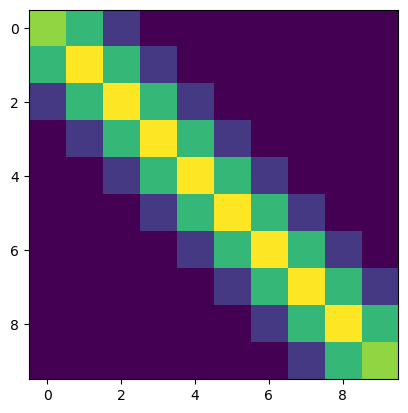

In [ ]:
plt.imshow(conv.data[0, 0, :, :])

In [ ]:
from tidygrad.utils.datasets import MNIST


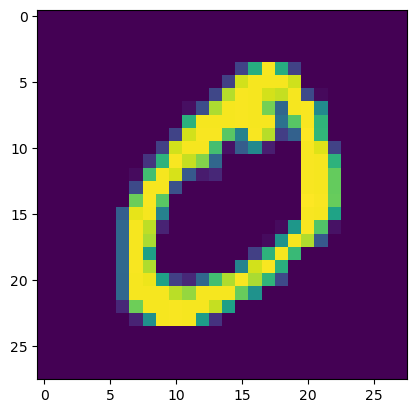

<matplotlib.image.AxesImage>

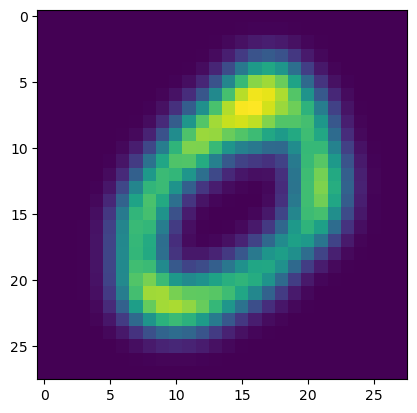

In [ ]:

mnist = MNIST()

x = Tensor(mnist[1][0][None][None], "x")
plt.show(plt.imshow(x.data[0, 0]))

conv = Conv2D(x, kernel, bias, padding=1).out
conv = Conv2D(conv, kernel, bias, padding=1).out
conv = Conv2D(conv, kernel, bias, padding=1).out
plt.imshow(conv.data[0, 0, :, :])